## Overview of functionalities

This notebook gives an overview of the functionalities of the dhydamo module.

For install instructions see: https://github.com/openearth/dhydamo#installation

Note that the old version of the package (delft3dfmpy) will not be updated anymore and won't be available through GitHub. New features (RR-modelling, additional hydraulic structures, etc.), will be implemented in dhydamo.

Furthermore, it should be noted that recently added features were tested with dummy-data, which is included with this package. The generated model is, therefore, not necessarily a correct hydraulic representation, as some dummy structures were added and existing structures moved and/or adjusted. The purpose of this notebook is solely to illustrate the usage of the dhydamo module.

This notebook is identical to the '_coupled_RRFM' variant, albeit that there is no RR component and all laterals are filled with time series.

## Release notes

The following aspects are new compared to the previous version:
 - culvert length is derived from HyDAMO setting in the GML file instead of the line geometry;
 - spelling of parametrised is now consistent, i.e., "dflowfmmodel.paratemeterised" would now give an error;
 - pumps now expect their margins in m+NAP instead of cm. I.e., the margins are now used directly to set the start/stoplevelsuctionside. Previously they were related to the 'streefwaarde';
 - Boundary conditions can be added to the model as 'dfmmodel.external_forcings.io.from_hydamo(hydamo.boundary_conditions)' instead of running 'add_boundary_condition' in a loop. This does not work (yet) for time series, only for constant boundary conditions
 - structures bridge, universal weir, compound structure and orifice are added. For culverts an 'afsluitmiddel' can be added. If it is 5 (terugslagklep) the flow-direction is set to positive, if it is 4 (schuif), a valve is added.
 - the module was breaking down when pandas was updated to version 1.0.1. Further updating to 1.0.3 fixes this. It is therefore, recommended to upgrade Pandas to at least 1.0.3. Previous workarounds have been removed again.  
 - functionality has been implemented to generate also the RR-components of a coupled RR-FM D-HYDRO model.
 - the old format external-forcingsfile, and assiciated tim-files, are not used anymore. Boundaries, laterals and intial conditions have been updated to the new format, where time series are included in a .bc-file.
 - MDU file has ben updated to version 1.09
 - culverts can be combined with 'afsluitmiddel': terugslagklep (flow-direction set to positive) or a valve. The afsluitmiddel points to a culvert using the HyDAMO field 'codegerelateerdobject'.
 - Orifices can be specificied using a separate input file. It contains a field 'schuifhoogte' and 'maximaaldebiet' to limit discharge. "Schuifhoogte' can be specified as a timeseries, similar to the kruinhoogte of a weir.
 

In [23]:
# Basis
import os
import sys
import shutil
import numpy as np

# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from delft3dfmpy import DFlowRRModel, DFlowRRWriter
from delft3dfmpy.datamodels.common import ExtendedGeoDataFrame
#from delft3dfmpy import *

# For reading SOBEK results as boundary conditions
# hkvsobekpy requires the modules fire and tqdm, install these (conda install fire tqdm)
import hkvsobekpy

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

### Read HYDAMO

Note: the data are also added in zipped format, to be unzipped in case of errors with the downloaded gml-files.

In the code section below the different parts or the HyDAMO gml are added. For more info on how to import the different elements from the HyDAMO gml, see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview

The general steps for importing the HyDAMO files are:
- Read the objects from the GML file.
- Snap the structures to the branches
- Remove non-snapped structures, perhaps because the distance to the nearest branch was too large.

A few remarks:
- The converter requires a number of features with a specfic name. If the name in the gml does not match this name, it can be converted with the 'column_mapping'
- The branch or structure data can also be loaded from shapefiles. Note that shapefiles have a max column length o f10 characters, so probably a lot of column_mapping is necessary.

Change this path to access the data!

In [24]:
# pad to the package containing the dummy-data
pad = 'D:/3640.20/delft3dfmpy.git/trunk/data/'

In [25]:
# initialize the class
hydamo = HyDAMO(extent_file=pad+'gis/selectie_pilot.shp')

# Branches
hydamo.branches.read_gml(pad+'gml/hydroobject.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.branches['ruwheidstypecode'] = 4

# read from GML
hydamo.crosssections.read_gml(pad+'gml/dwarsprofiel.gml' , 
                              column_mapping={'ruwheidswaardelaag':'ruwheidswaarde'} ,
                              index_col='profielcode' ,
                              groupby_column='profielcode' , 
                              order_column='codevolgnummer')

hydamo.crosssections.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.crosssections.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.crosssections.drop('code', axis=1, inplace=True)
hydamo.crosssections.rename(columns={'profielcode': 'code'}, inplace=True)

hydamo.parametrised_profiles.read_gml(pad+'gml/NormGeparametriseerdProfiel.gml', column_mapping={'ruwheidswaardelaag': 'ruwheidswaarde'})
hydamo.parametrised_profiles.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.parametrised_profiles.dropna(axis=0, inplace=True, subset=['branch_offset'])

# # Bridges
hydamo.bridges.read_gml(pad+'gml/brug.gml')
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])

# # Culverts
hydamo.culverts.read_gml(
   pad+'gml/duikersifonhevel.gml',
   index_col='code',
   column_mapping={'vormkoker': 'vormcode'},
   clip=hydamo.clipgeo
)
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])
duikers_rekentijd = ['RS372-KDU3','RS375-KDU2','RS373-KDU7','RS373-KDU20','RS373-KDU22','RS373-KDU19']
duikers_gemalen = ['OWL32921-KDU3','RS375-KDU6']             
hydamo.culverts.drop(duikers_rekentijd, axis=0, inplace=True)
hydamo.culverts.drop(duikers_gemalen, axis=0, inplace=True)

# Weirs (including universal weirs)
hydamo.weirs.read_gml(pad+'gml/stuw.gml')
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Orifices
hydamo.orifices.read_gml(pad+'gml/onderspuier.gml')
hydamo.orifices.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=2)
hydamo.orifices.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Closing devices / terugslagkleppen e.d.
hydamo.afsluitmiddel.read_gml(pad+'gml/afsluitmiddel.gml', index_col='code')

# Laterals (imported from shapefile)
hydamo.laterals.read_shp(pad+'sobekdata/Sbk_S3BR_n.shp', 
                         column_mapping={'ID        ': 'code', 
                                         'NAME      ': 'name',
                                         'X         ':'X',
                                         'Y         ':'Y'})
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=  5)
hydamo.laterals.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Pumps
hydamo.gemalen.read_gml(pad+'gml/gemaal.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.read_gml(pad+'gml/pomp.gml', index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.pumps['maximalecapaciteit'] *= 60
hydamo.sturing.read_gml(pad+'gml/sturing.gml', index_col='code')


Plot the model with branches, cross sections and structures. Note that compound structures are not plotted here as they do not have a geometry on their own; they are composed from their sub-structures that do have a geometry and are plotted here.

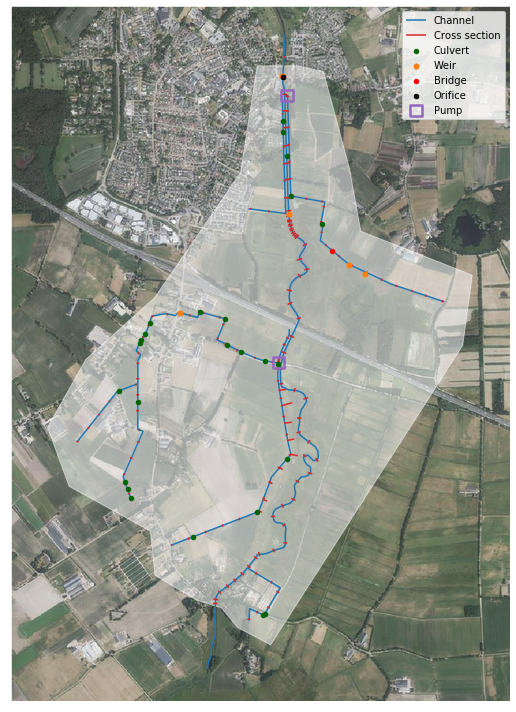

In [26]:
plt.rcParams['axes.edgecolor'] = 'w'

fig, ax = plt.subplots(figsize=(10, 10))

ax.fill(*hydamo.clipgeo.exterior.xy, color='w', alpha=0.5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread(pad+'gis/achtergrond.png')
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.branches.plot(ax=ax, label='Channel')
hydamo.crosssections.plot(ax=ax, color='C3', label='Cross section')
hydamo.culverts.centroid.plot(ax=ax, color='darkgreen', label='Culvert', markersize=20, zorder=10)
hydamo.weirs.centroid.plot(ax=ax, color='C1', label='Weir', markersize=25, zorder=10)
hydamo.bridges.plot(ax=ax,color='red',label='Bridge',markersize=20,zorder=10)
hydamo.orifices.plot(ax=ax,color='black',label='Orifice',markersize=20,zorder=10)
hydamo.pumps.plot(
    ax=ax, color='C4', label='Pump', marker='s', markersize=125, zorder=10, facecolor='none', linewidth=2.5)

ax.legend()

fig.tight_layout()

### Generate the D-HYDRO FM schematisation

#### Create the 1D network

Convert the geometries to D-HYDRO schematisation:

Start with importing the structures (from HyDAMO in this case), since the position of the structure can be used in defining the position of the 1d nodes. 

Structures can also be added without the HyDAMO imports. One weir is added manually, but this can be done for all implemented structures.

Note that for importing most structures multiple gml-files are needed. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

 - for weirs, a corresponding profile is looked up in the crossections. If one is found (either a YZ or a parametrised profile) the weir is implemented as a universal weir. If it is not found, a regular (rectangular) weir will be used. The cross-section should contain a 'codegeralateerdobject' containing the ID of the universal weir.
 - culverts can also use an 'afsluitmiddel'; if one is coupled for a specific culvert and its type is 5 (terugslagklep) the flow direction is set 'positive' instead of 'both'. If the type is 4 (schuif), a valve will be implemented.
 - bridges need an associated crosssection (through the field 'codegerelateerdobject' in the cross-section); this can be either 'YZ' or 'parametrised'. The profiles are then processed so a suitable cross-section for a bridge is created;
 - pumps are composed from 'gemalen', 'pompen' and 'sturing'.

In most cases, these 'extra' arguments are optional, i.e. they are not required and can be left out. Some are required:
- pumps really need all 3 objects (gemalen, pompen en sturing);
- bridges really need a profile (either 'crosssections' or 'parametrised_profiles' needs to contain a field 'codegerelateerdobject' that points to each bridge).

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.

Note that orifices do not yet have an appropriate/definitive definition in HYDAMO. To be able to use it, we now use a separate GML-definition ('onderspuier") but possibly this will be integrated in the definition for weirs. To be continued.


In [27]:
dfmmodel = DFlowFMModel()

# Collect structures
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, hydamo.afsluitmiddel)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.orifices_from_hydamo(hydamo.orifices)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.sturing, gemalen=hydamo.gemalen)

# Add a weir manually (equivalent functions exist for all structures):
dfmmodel.structures.add_weir(
    id='extra_weir',
    branchid='riv_RS1_1810',
    chainage=950.0,
    crestlevel=8.00,
    crestwidth=7.5,
    corrcoeff=1.0    
)


Compound structures are composed of other structures and will not be implemented as such in HyDAMO. D-Flow FM simply needs an ID for every compound structure and a list of structures it should be composed of. They should be snapped to the same branch but not necessarily to the exact same location.

To use, provide a list of ID's of compound structures, and along with, for every compound structure, a nested list of sub-structures. If there are many, these can be read from files (for example).

In [28]:
cmpnd_ids  = ['cmpnd_1','cmpnd_2']
cmpnd_list = [['Orifice_Test1','UWeir_Test2'],
              ['UWeir_Test2','RS1-KBR31']]
dfmmodel.structures.io.compound_structures(cmpnd_ids, cmpnd_list)

After this add the branches and generate a grid.

In [29]:
# Create a 1D schematisation
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=40.0, seperate_structures=True)

Add cross sections. Here two hydamo files are used. First the imported cross sections. If after this there are branch objects left without a cross sections, it is derived from the norm parametrised profile (Dutch: legger).

In [30]:
# Add cross sections from hydamo
dfmmodel.crosssections.io.from_hydamo(
    dwarsprofielen=hydamo.crosssections,
    parametrised=hydamo.parametrised_profiles,
    branches=hydamo.branches
)

print(f'{len(dfmmodel.crosssections.get_branches_without_crosssection())} branches are still missing a cross section.')
print(f'{len(dfmmodel.crosssections.get_structures_without_crosssection())} structures are still missing a cross section.')

1 branches are still missing a cross section.
0 structures are still missing a cross section.


If there are still missing cross sections left, add a default one. To do so add a cross section definition, and assign it with a vertical offset (shift).

In [31]:
# Set a default cross section
default = dfmmodel.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30)
dfmmodel.crosssections.set_default_definition(definition=default, shift=5.0)

#### Add a 2D mesh

To add a mesh, currently 2 options exist:

1) the converter can generate a relatively simple, rectangular mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

- Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
- Refine along the main branch
- Determine altitude from a DEM.

The 'refine'-method requires the dflowfm.exe executable. If this is not added to the system path, it can be provided in an optional argument to refine (dflowfm_path).

In [32]:
# Create mesh object
mesh = Rectangular()
cellsize = 25

# Generate mesh within model bounds
mesh.generate_within_polygon(hydamo.clipgeo, cellsize=cellsize, rotation=0)

# Refine the model (2 steps) along the main branch. To do so we generate a buffer around the main branch.
buffered_branch = hydamo.branches.loc[['riv_RS1_1810', 'riv_RS1_264'], 'geometry'].unary_union.buffer(10)
mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize, dflowfm_path=r'D:\3640.20\dfm')

# Determine the altitude from a digital elevation model
# rasterpath = '../gis/AHNdommel_clipped.tif'
# mesh.altitude_from_raster(rasterpath)

# The full DEM is not added to this notebook. Instead a constant bed level is used
mesh.altitude_constant(15.0)

# Add to schematisation
dfmmodel.network.add_mesh2d(mesh)

2) a more complex mesh can be created in other software (such as SMS) and then imported in the converter: (uncomment to activate)

In [33]:
#from dhydamo.core.mesh2d import Mesh2D
#mesh = Mesh2D()
# import the geometry
#mesh.geom_from_netcdf(r'T:\2Hugo\Grid_Roer_net.nc')
# fill every cell with an elevation value
#mesh.altitude_from_raster(rasterpath)
# and add to the model
#dfmmodel.network.add_mesh2d(mesh)

#### Add the 1D-2D links

For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node (intersecting==True)
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells (intersecting==True).

Intersecting indicates whether or not the 2D cells cross the 1D network (lateral versus embedded links).
So, option 3 is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

In [34]:
del dfmmodel.network.links1d2d.faces2d[:]
del dfmmodel.network.links1d2d.nodes1d[:]
dfmmodel.network.links1d2d.generate_1d_to_2d(max_distance=50)

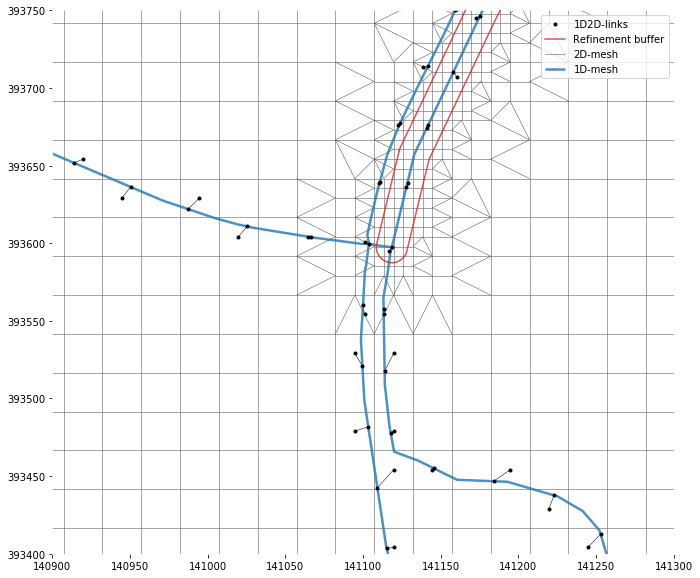

In [35]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_aspect(1.0)

segments = dfmmodel.network.mesh2d.get_segments()
ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-mesh'))

links = dfmmodel.network.links1d2d.get_1d2dlinks()
ax.add_collection(LineCollection(links, color='k', linewidths=0.5))
ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='k', marker='.', ls='', label='1D2D-links')

for i, p in enumerate([buffered_branch]):
    ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

hydamo.branches.plot(ax=ax, color='C0', lw=2.5, alpha=0.8, label='1D-mesh')

ax.legend()

ax.set_xlim(140900, 141300)
ax.set_ylim(393400, 393750);

### Boundary conditions for FM

Add boundary conditions to external forcings from a SOBEK time series.

In [36]:
bcs = pd.read_csv(pad+'sobekdata/boundaryconditions.csv', sep=';', index_col=0)
bcs.index = pd.to_datetime(bcs.index)

In [37]:
dfmmodel.external_forcings.add_boundary_condition(
    name='BC_flow_in',
    pt=(140712.056047, 391893.277878),
    bctype='discharge',
    series=bcs['Discharge']
)

dfmmodel.external_forcings.add_boundary_condition(
    name='BC_wlev_down',
    pt=(141133.788766, 395441.748424),
    bctype='waterlevel',
    series=bcs['Waterlevel']
)

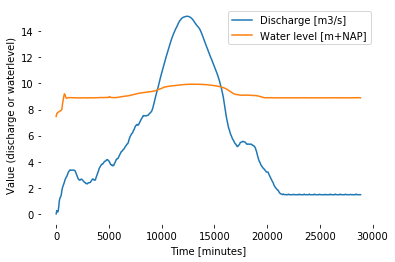

In [38]:
fig, ax = plt.subplots()

ax.plot(
    dfmmodel.external_forcings.boundaries['BC_flow_in']['time'],
    dfmmodel.external_forcings.boundaries['BC_flow_in']['value'],
    label='Discharge [m3/s]'
)

ax.plot(
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['time'],
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['value'],
    label='Water level [m+NAP]'
)

ax.set_ylabel('Value (discharge or waterlevel)')
ax.set_xlabel('Time [minutes]')

ax.legend();

In [39]:
# Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

Lateral flow can be obtained from the coupling with the RR-model, or by providing time series. Here, these are read from a Sobek model. In the coupling below, nodes that are not linked to a RR-boundary node are assumed to have a prescribed time series.

If a DFM-model is run offline, timeseries should be provided for all laterals.

In [40]:
###For adding the lateral inflow we import SOBEK results. To do so we use hkvsobekpy. For more info on this module, see: https://github.com/HKV-products-services/hkvsobekpy
# # Add the lateral inflows also from the SOBEK results. Naote that the column names in the his-file need to match
# # the id's of the imported lateral locations at the top of this notebook.
rehis = hkvsobekpy.read_his.ReadMetadata(pad+'sobekdata/QLAT.HIS', hia_file='auto')
param = [p for p in rehis.GetParameters() if 'disch' in p][0]
lateral_discharge = rehis.DataFrame().loc[:, param]
lateral_discharge.drop('lat_986', inplace=True, axis=1)

Observation points are now written in the new format, where once can discriminate between 1D ('1d') and 2D ('2d') observation points. This can be done using the optional argument 'locationTypes'. If it is omitted, all points are assumed to be 1d. 1D-points are always snapped to a the nearest branch. 2D-observation points are always defined by their X/Y-coordinates.

Note: add_points can be called only once: once dfmodel.observation_points is filled,the add_points-method is not available anymore.

In [41]:
dfmmodel.observation_points.add_points([(141150, 393700),(141155, 393705),(145155, 394705),(145150, 394700)],['ObsPt1','ObsPt2','ObsPt2D1','ObsPt2D2'], locationTypes=['1d','1d','2d','2d'])

In [42]:
dfmmodel.observation_points

,name,branchId,chainage,geometry,locationType,x,y
name,,,,,,,
ObsPt1,ObsPt1,riv_RS1_1810,107.465,POINT (141150.000 393700.000),1d,NaN,NaN
ObsPt2,ObsPt2,riv_RS1_1810,114.127,POINT (141155.000 393705.000),1d,NaN,NaN
ObsPt2D1,ObsPt2D1,NaN,NaN,POINT (145155.000 394705.000),2d,145155.0,394705.0
ObsPt2D2,ObsPt2D2,NaN,NaN,POINT (145150.000 394700.000),2d,145150.0,394700.0


In [43]:
dfmmodel.external_forcings.io.read_laterals(hydamo.laterals, lateral_discharges=lateral_discharge)

### Settings and writing

Finally, we adjust some settings and export the coupled FM-RR model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'; RR-files are written to 'rr'. An XML-file (dimr-config.xml) describes the coupling between the two. Note that both the GUI and Interaktor do not (yet) support RR, so the only way to carry out a coupled simulation is using DIMR.


In [44]:
# Runtime and output settings
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20000101
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] = 24.0 * 1 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7

# Create writer
fm_writer = DFlowFMWriter(dfmmodel, output_dir=pad+'testmodel_fmonly', name='moergestels_broek')

# Write as model
fm_writer.objects_to_ldb()
fm_writer.write_all()

C:\Users\hurkmans\Appdata\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Finished!